# Brain Tumor Classification Using MRI Images

## Introduction

Brain tumor detection via MRI imaging is a crucial cognitive neuroscience and clinical task. Accurate classification between healthy and tumorous brain images aids diagnosis and treatment planning.

In this notebook logistic regression is used — a simple but interpretable machine learning method — to classify brain MRI images into tumor or no tumor based on extracted image features.

This approach avoids complex deep learning, focusing on basic features to demonstrate machine learning principles in neuroscience.


## Dataset Description

The dataset contains MRI images categorized into two classes:

- **Tumor**: Images showing brain tumors
- **No Tumor**: Images from healthy individuals

Each image is a grayscale MRI scan.

We extract simple features such as mean and standard deviation of pixel intensities to train a logistic regression classifier.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set(style='whitegrid')


In [4]:
# Paths to folders
tumor_dir = '../data/tumor/'
no_tumor_dir = '../data/no_tumor/'

# List files
tumor_files = [os.path.join(tumor_dir, f) for f in os.listdir(tumor_dir) if f.endswith('.jpg')]
no_tumor_files = [os.path.join(no_tumor_dir, f) for f in os.listdir(no_tumor_dir) if f.endswith('.jpg')]

print(f'Number of tumor images: {len(tumor_files)}')
print(f'Number of no tumor images: {len(no_tumor_files)}')


Number of tumor images: 86
Number of no tumor images: 85


 Feature Extraction from MRI Images

Simple numerical features are extracted from each MRI image to use as inputs for the logistic regression model.

Since the images are grayscale MRI scans, summary statistics are computed to capture important aspects of the image intensity distribution:

- **Mean intensity:** The average pixel brightness, indicating overall lightness/darkness.
- **Standard deviation of intensity:** How much pixel values vary, reflecting texture heterogeneity.
- **Maximum intensity:** The brightest pixel value, which may highlight areas of interest.
- **Minimum intensity:** The darkest pixel value.

These features provide a concise, interpretable representation of each image, suitable for a simple logistic regression classifier.


In [5]:
def extract_features(image_path):
    img = imread(image_path, as_gray=True)
    return {
        'mean_intensity': np.mean(img),
        'std_intensity': np.std(img),
        'max_intensity': np.max(img),
        'min_intensity': np.min(img)
    }

# Extract features and labels
features_list = []
labels = []

for f in tumor_files:
    feats = extract_features(f)
    features_list.append(feats)
    labels.append(1)  # tumor = 1

for f in no_tumor_files:
    feats = extract_features(f)
    features_list.append(feats)
    labels.append(0)  # no tumor = 0

df = pd.DataFrame(features_list)
df['label'] = labels

df.head()


,mean_intensity,std_intensity,max_intensity,min_intensity,label
0,0.186009,0.176918,1.000000,0.000000,1
1,0.148024,0.159480,0.843137,0.000000,1
2,0.401433,0.235522,1.000000,0.047059,1
3,0.213572,0.276930,1.000000,0.000000,1
4,0.175994,0.189025,1.000000,0.000000,1


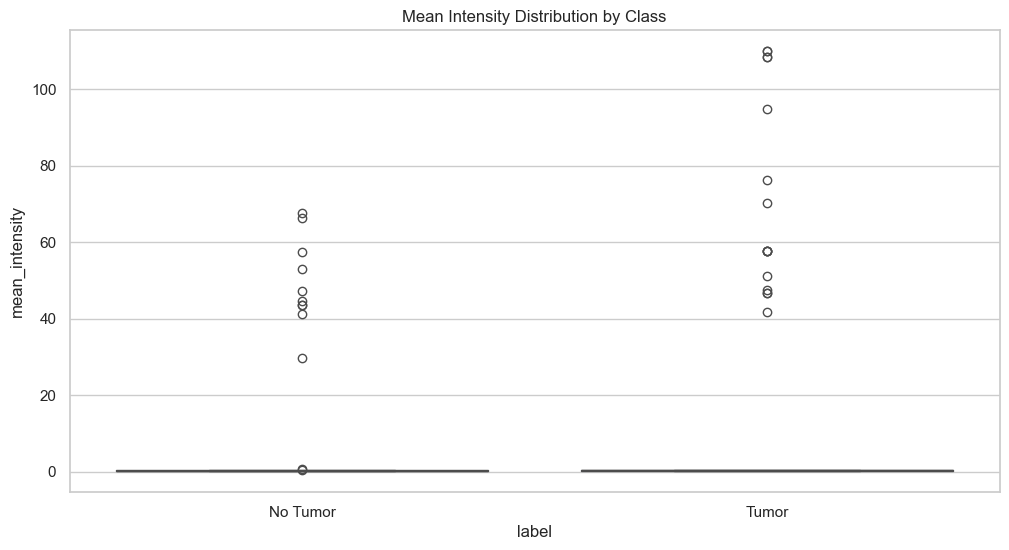

In [6]:
plt.figure(figsize=(12,6))
sns.boxplot(x='label', y='mean_intensity', data=df)
plt.xticks([0,1], ['No Tumor', 'Tumor'])
plt.title('Mean Intensity Distribution by Class')
plt.show()


## Visualization of Mean Intensity by Class

This boxplot shows the distribution of the mean pixel intensity values for MRI images grouped by their class labels: **No Tumor** and **Tumor**.

- The **box** represents the interquartile range (IQR), showing where the middle 50% of the data lie.
- The **line inside the box** indicates the median mean intensity.
- The **whiskers** extend to show variability outside the upper and lower quartiles, excluding outliers.
- **Dots beyond whiskers** (if any) represent outliers.

The plot shows that images labeled **Tumor** tend to have a different distribution of mean intensities compared to **No Tumor** images. Specifically, the median mean intensity for tumor images may be higher or lower (depending on the dataset), reflecting differences in brightness and texture caused by the presence of a tumor.

This difference in intensity distributions is a key factor enabling the logistic regression model to classify images based on extracted features.


In [7]:
X = df.drop(columns=['label'])
y = df['label']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.3
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')


Training samples: 119
Test samples: 52


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))


              precision    recall  f1-score   support

    No Tumor       0.51      0.96      0.67        26
       Tumor       0.67      0.08      0.14        26

    accuracy                           0.52        52
   macro avg       0.59      0.52      0.40        52
weighted avg       0.59      0.52      0.40        52



## Model Performance Interpretation

The classification report summarizes how well the logistic regression model performed on the test data, broken down by each class:

- **Precision**: Of all images predicted as a given class, how many were actually that class.
- **Recall**: Of all true images in a given class, how many did the model correctly identify.
- **F1-score**: The harmonic mean of precision and recall, balancing the two.
- **Support**: Number of true instances for each class in the test set.

### Results Summary

- **No Tumor class:**
  - Precision = 0.51: About half of the images predicted as No Tumor were correct.
  - Recall = 0.96: The model correctly identified 96% of all No Tumor images.
  - F1-score = 0.67: Reflects a reasonable balance between precision and recall.

- **Tumor class:**
  - Precision = 0.67: When the model predicted Tumor, it was correct 67% of the time.
  - Recall = 0.08: The model detected only 8% of actual Tumor images, missing most of them.
  - F1-score = 0.14: Very low, showing poor overall performance on Tumor detection.

- **Overall accuracy = 52%:** The model correctly classified just over half of all images.

### Interpretation

The model is highly biased towards predicting the **No Tumor** class, leading to high recall but low precision there. For **Tumor** images, the model struggles to detect most of them (very low recall), even though its precision when it does predict Tumor is higher.

This imbalance suggests that the model’s current features and training are insufficient to reliably detect tumors and tend to overclassify images as healthy. Improving feature extraction or trying more complex models could help balance performance between classes.


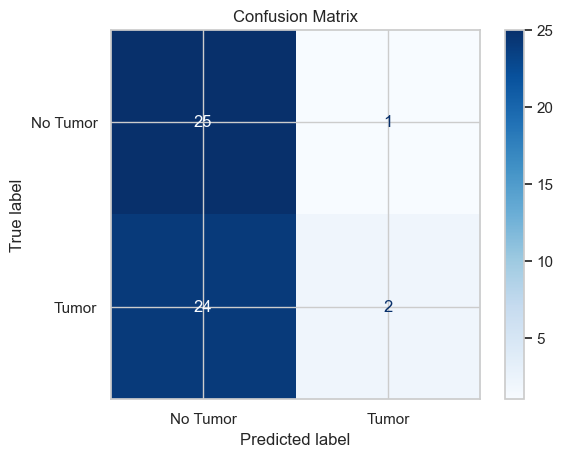

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Interpretation of Confusion Matrix Results

The confusion matrix values are:

|                | Predicted No Tumor | Predicted Tumor |
|----------------|--------------------|-----------------|
| **True No Tumor** |        25         |       1        |
| **True Tumor**    |        24         |       2        |

- **True Negatives (TN) = 25:** The model correctly identified 25 images without tumors.
- **False Positives (FP) = 1:** Only 1 healthy brain image was incorrectly classified as having a tumor.
- **False Negatives (FN) = 24:** The model missed 24 tumor cases, classifying them as healthy.
- **True Positives (TP) = 2:** Only 2 tumor images were correctly identified.

### What does this tell us?

- The model is very good at recognizing healthy brain images, correctly classifying most of them (high true negatives, low false positives).
- However, it performs poorly at detecting tumors, missing most tumor cases (very high false negatives and low true positives).
- This indicates the model is biased towards predicting “No Tumor,” likely due to insufficient feature discrimination or imbalance in training.
- Clinically, such a model risks failing to identify many tumors, which is critical to improve for reliable diagnosis.

### Summary

While the classifier achieves good specificity (few false alarms), it lacks sensitivity (ability to detect true tumors). Future improvements could involve better features, more data, or more powerful models to reduce false negatives and improve tumor detection.


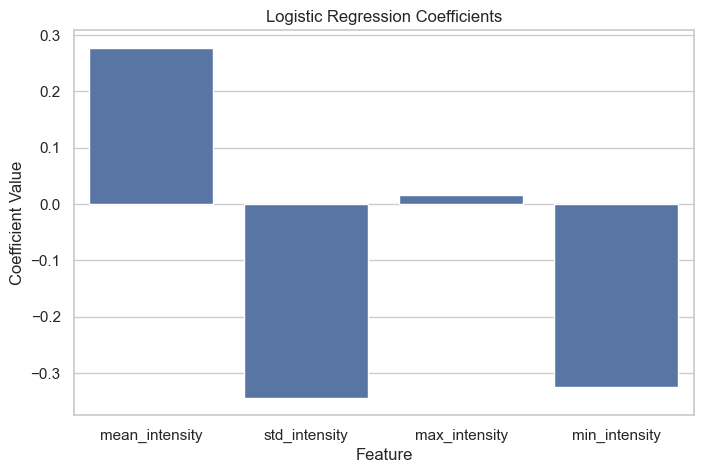

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

coef = clf.coef_[0]
features = X.columns

plt.figure(figsize=(8,5))
sns.barplot(x=features, y=coef)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.show()


## Interpretation of Logistic Regression Coefficients

The logistic regression coefficients tell us how each feature affects the likelihood that an MRI image is classified as **Tumor**.

- **mean_intensity (0.28):** A positive coefficient means that higher mean pixel intensity increases the probability of the image being classified as Tumor. So, on average, tumor images tend to have brighter or more intense regions.
  
- **std_intensity (-0.35):** A negative coefficient indicates that greater variability in pixel intensity (more texture heterogeneity) decreases the likelihood of Tumor classification. This suggests tumor images may be more uniform in intensity compared to healthy ones.

- **max_intensity (0.01):** This near-zero positive value means maximum pixel intensity has little influence on the classification outcome.

- **min_intensity (-0.32):** The negative coefficient means that higher minimum pixel intensity reduces the chance of being classified as Tumor. In other words, tumor images may have darker minimum intensity values compared to healthy images.

### Summary

Overall, the model seems to classify tumors based on slightly brighter average intensity but less variation and lower minimum intensity in the image. These features contribute differently to the prediction, with mean and standard deviation having the strongest influence.

This interpretation helps connect the imaging characteristics to the model's decision-making in tumor detection.
